Mandelbrot created on GPU in 0.188677 s


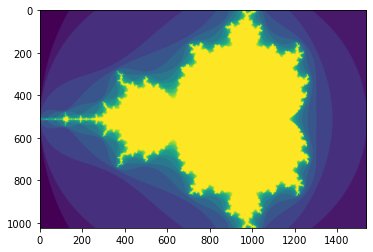

In [25]:
from numba import cuda
import numpy as np
from timeit import default_timer as timer

@cuda.jit(device=True)
def mandel(x, y, max_iters):
  """
  Given the real and imaginary parts of a complex number,
  determine if it is a candidate for membership in the Mandelbrot
  set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
  startY = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel(real, imag, iters)

gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 15) 
gimage=d_image
dt = timer() - start

print ("Mandelbrot created on GPU in %f s" % dt)
from matplotlib.pyplot import imshow
imshow(gimage)


In [9]:
import numpy as np
from numba import jit
import cupy as cp
import timeit

@jit
def Add(a,b):
    A=cp.asarray(a)
    B=cp.asarray(b)
    return cp.asnumpy(A+B)
@jit
def tcp():
    N = 100000
    A = cp.ones(N, dtype=np.float32)
    B = cp.ones(A.shape, dtype=A.dtype)
    C = cp.empty_like(A, dtype=A.dtype)
    C = A*B
@jit
def tnp():
    N = 100000
    A = np.ones(N, dtype=np.float32)
    B = np.ones(A.shape, dtype=A.dtype)
    C = np.empty_like(A, dtype=A.dtype)
    C = A*B

%timeit tcp
%timeit tnp

20.6 ns ± 1.83 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
19.5 ns ± 2.06 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


# CUDA for numba


In [5]:
from numba import cuda
import numpy as np

@cuda.jit
def my_kernal(io_array):
    ''' 
    kernal code
    '''
    pos=cuda.grid(1)
    if pos<io_array.size:
        io_array[pos]*=2

def tsample():
    data=np.linspace(0,10,256)
    thread_per_block=256
    block_per_grid=int(data.shape[0]/thread_per_block)
    # print(block_per_grid)
    my_kernal[block_per_grid,thread_per_block](data)
    # print(data)

%timeit tsample

21.2 ns ± 1.18 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
